## Histopathologic Cancer Detection
The purpose of this jupyter notebook is to create a learning algorithm to identify **metastatic cancer** in small image patches taken from larger digital pathology scans. 

You can find out more about this problem/competition [Here](https://www.kaggle.com/c/histopathologic-cancer-detection)

### Plan of action
We will first load all libraries to both explore and work with the data. 

We will then take a deeper dive into the data, to get an understanding of how labeling takes place

After we will be utilizing **Fast AI's** Deep Learning Framework (Built on top of Pytorch) to first create a *data object*, come up with data augmentation methods, and finally experiment with a *pretrained, resnet34* model 

Later, we will experiment with a larger ResNet model and other fine-tuned regularization techniques 

Eventually we will use Test Time Augmentation 

Finally we will use this to submit our predictions

In [1]:
!pip install kaggle --upgrade
!pip install fastai

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.2)
  Stored in directory: /root/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Successfully built wrapt
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: wrapt 1.11.1
    Uninstalling wrapt-1.11.1:
      Successfully uninstalled wrapt-1.11.1


In [0]:
import pandas as pd
import numpy as np

from fastai import *
from fastai.vision import *

import os
import torch
from torchvision.models import *

In [3]:
# checking if enabled
torch.backends.cudnn.enabled == True

True

In [4]:
# configuring kaggle
!mkdir .kaggle # we will store in this directory

cred = json.dumps({"username":"USERNAME","key":"KEY"}) # change with your credentials
with open('.kaggle/kaggle.json', 'w') as f:
  f.write(cred) # writes to the .kaggle folder
  
# Configuring the file - we will run this twice (second time next block)
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.2', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 487, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2728, in load_entry_point
    return ep.load()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2346, in load
    return self.resolve()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2352, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/

In [5]:
# run for second time
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
# making private
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Creating directories and paths
!mkdir data
!mkdir data/images # will contain all raw images

path = '/content/data'
images_path = '/content/data/images'

In [8]:
os.listdir(path)
os.listdir(images_path)

[]

In [9]:
# Downloading our images
!kaggle competitions download -c histopathologic-cancer-detection -f train.zip -p {path}
!kaggle competitions download -c histopathologic-cancer-detection -f train_labels.csv -p {path}

100% 4.98G/4.98G [02:14<00:00, 48.7MB/s]
100% 4.98G/4.98G [02:14<00:00, 39.7MB/s]
 98% 5.00M/5.10M [00:00<00:00, 5.80MB/s]
100% 5.10M/5.10M [00:00<00:00, 5.85MB/s]


In [0]:
# Unzipping files
!unzip -q -n {path}/train.zip -d {images_path} 
!unzip -q -n {path}/train_labels.csv.zip -d {path}

In [0]:
# Removing zip file
!rm -rf {path}/train.zip
!rm -rf {path}/train_labels.csv.zip

### Data Exploration

In [0]:
# Let's create paths
path = '/content/data'
images_path = '/content/data/images'
labels_path = '/content/data/train_labels.csv'

In [13]:
!ls data

images	train_labels.csv


In [14]:
# getting df
df = pd.read_csv(labels_path)
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [15]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

### Creating Dataset

In [0]:
# Function to get our data
def get_data(image_size, batch_size, tfms):
  np.random.seed(42)
  data = ImageDataBunch.from_csv(path,csv_labels='train_labels.csv',folder='images', ds_tfms=tfms, size=image_size, suffix='.tif',bs=batch_size);
  stats=data.batch_stats()        
  data.normalize(stats)
  
  return data

### Building our model

In [0]:
arch_resnet = models.resnet34
# arch_densenet = densenet196

In [0]:
# Setting transforms
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)

In [0]:
batch_size = 64
image_size = 96

In [0]:
data = get_data(image_size, batch_size, tfms)

In [21]:
# Creating learner
learn = create_cnn(data, arch_resnet, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 68156725.69it/s]


In [22]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.281585,0.240593,0.096398,0.903602
2,0.228285,0.190901,0.072674,0.927326
3,0.204704,0.167557,0.062334,0.937666
4,0.188063,0.153693,0.056880,0.943120
5,0.192551,0.151527,0.056380,0.943620


In [0]:
learn.save('1-resnet34')

### ResNet50

In [24]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy,error_rate])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 68573085.19it/s]


epoch,train_loss,valid_loss,accuracy,error_rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


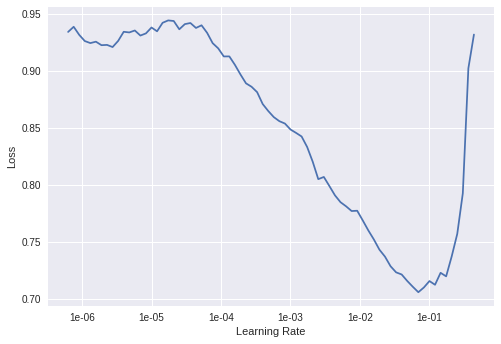

In [25]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 3e-2

In [27]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.258153,0.403920,0.888376,0.111624
2,0.239334,0.210090,0.917987,0.082013
3,0.219135,0.188179,0.928508,0.071492
4,0.181345,0.151692,0.944779,0.055221
5,0.159811,0.138546,0.949460,0.050540
